## Risk Plots

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import qinfer as qi
import models as m_
from adaptive import *
from nvdata import *

### Parallelization Setup

The following sets up the `dview` object used for parallelizing models across CPU cores. Go to the Jupyter "IPython Clusters" tab to start up the default cluster.

In [2]:
from ipyparallel import Client
rc = Client(profile='default2')
dview = rc[:]
dview.use_dill()

with dview.sync_imports():
    import os

# Change directory on engines so that we can import models.
if dview.execute('os.chdir("{}")'.format(os.getcwd())).get():
    print "Changed engine directories to notebook directory."

# To ensure that we don't enter into a Matplotlib event loop
# on our engines, we set the MPLBACKEND to the non-interactive
# Agg backend first. This is especially useful if the engines
# are connected via SSH.
if dview.execute('os.environ["MPLBACKEND"] = "Agg"').get():
    print "Changed MPL backend."

# Force each engine to import QInfer before proceeding.
if dview.execute('import qinfer as qi').get():
    print "Successfully imported QInfer on engines."

if dview.execute('import models').get():
    print "Successfully imported models."

print "Engines connected: {}".format(len(rc.ids))

importing os on engine(s)
Changed engine directories to notebook directory.
Changed MPL backend.
Successfully imported QInfer on engines.
Successfully imported models.
Engines connected: 12


### Models

In [3]:
ham_model = m.RabiRamseyModel()
ex_model = m.RabiRamseyExtendedModel(10, 3)
par_ham_model = qi.DirectViewParallelizedModel(ham_model, dview)
par_ex_model = qi.DirectViewParallelizedModel(ex_model, dview)

### Convenient Prior for testing risk

`custom_prior(1)` is roughly the posterior after one experimental trial, `custom_prior(200)` is a very wide prior with the same mean.

In [4]:
true_value = np.array([11.6,1.79,1.74778949,2.22,0.61])
target_stds = np.array([0.01,0.01,0.15,0.02,0.05])
def custom_prior(multiplier):
    return qi.ProductDistribution(
        qi.GammaDistribution(mean=true_value[0], var=(multiplier * target_stds[0])**2),
        qi.GammaDistribution(mean=true_value[1], var=(multiplier * target_stds[1])**2),
        qi.NormalDistribution(mean=true_value[2], var=(multiplier * target_stds[2])**2),
        qi.GammaDistribution(mean=true_value[3], var=(multiplier * target_stds[3])**2),
        qi.GammaDistribution(mean=true_value[4], var=(multiplier * target_stds[4])**2),
    )

def extended_prior(multiplier):
    return qi.ProductDistribution(
        qi.GammaDistribution(mean=true_value[0], var=(multiplier * target_stds[0])**2),
        qi.GammaDistribution(mean=true_value[1], var=(multiplier * target_stds[1])**2),
        qi.NormalDistribution(mean=true_value[2], var=(multiplier * target_stds[2])**2),
        qi.GammaDistribution(mean=true_value[3], var=(multiplier * target_stds[3])**2),
        qi.GammaDistribution(mean=true_value[4], var=(multiplier * target_stds[4])**2),
        *([qi.GammaDistribution(mean=1, var=(0.01)**2)] * 6)
    )

ref_prior = qi.UniformDistribution(
    [[0.019,0.021],[0.014,0.016]]
)

### Timing

In [5]:
updater = qi.SMCUpdater(par_ham_model, 2000, custom_prior(10))
%timeit -n 1 -r 1 updater.bayes_risk(rabi_sweep(max_t=1, n=200, wo=0))
%timeit -n 1 -r 1 updater.bayes_risk(ramsey_sweep(max_tau=2, n=200, tp=0.022, wo=0))

1 loop, best of 1: 985 ms per loop
1 loop, best of 1: 1.61 s per loop


In [17]:
model = m.ReferencedPoissonModel(par_ham_model)
model._domain = qi.IntegerDomain(min=100, max=200)
prior = qi.ProductDistribution(custom_prior(10), ref_prior)
updater = qi.SMCUpdater(model, 1000, prior)
%timeit -n 1 -r 1 updater.bayes_risk(rabi_sweep(max_t=1, n=200, wo=0, n_meas=100))
%timeit -n 1 -r 1 updater.bayes_risk(ramsey_sweep(max_tau=2, n=200, tp=0.022, wo=0, n_meas=100))
%timeit model.likelihood(np.arange(500), updater.particle_locations, rabi_sweep(max_t=1, n=200, wo=0, n_meas=100))

1 loop, best of 1: 6.72 s per loop
1 loop, best of 1: 7.28 s per loop
1 loop, best of 3: 8.35 s per loop


In [18]:
model = m.ReferencedPoissonModel(par_ham_model,dview=dview)
model._domain = qi.IntegerDomain(min=100, max=200)
prior = qi.ProductDistribution(custom_prior(10), ref_prior)
updater = qi.SMCUpdater(model, 1000, prior)
%timeit -n 1 -r 1 updater.bayes_risk(rabi_sweep(max_t=1, n=200, wo=0, n_meas=100))
%timeit -n 1 -r 1 updater.bayes_risk(ramsey_sweep(max_tau=2, n=200, tp=0.022, wo=0, n_meas=100))
%timeit model.likelihood(np.arange(500), updater.particle_locations, rabi_sweep(max_t=1, n=200, wo=0, n_meas=100))

1 loop, best of 1: 6.2 s per loop
1 loop, best of 1: 6.56 s per loop
1 loop, best of 3: 3.1 s per loop


### Rabi Risk

<IPython.core.display.Javascript object>


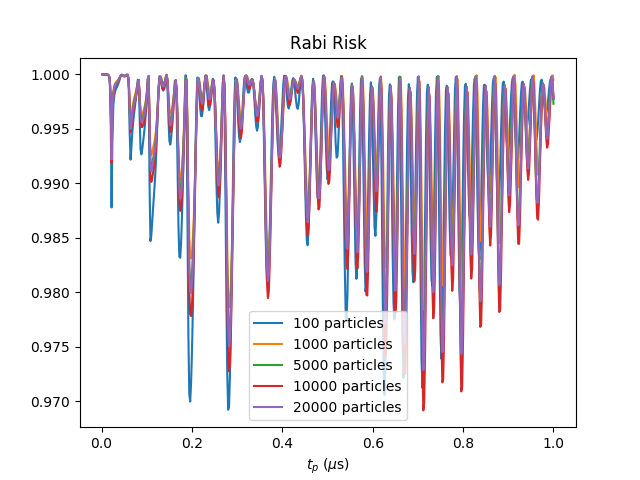

In [5]:
rabi_eps = rabi_sweep(max_t=1, n=500, wo=0)
fig = plt.figure()

for n_particles in [100,1000,5000,10000,20000]:
    updater = qi.SMCUpdater(par_ham_model, n_particles, custom_prior(10))
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    plt.plot(rabi_eps['t'], updater.bayes_risk(rabi_eps)/risk0, label='{} particles'.format(n_particles))
    
plt.legend()
plt.title('Rabi Risk')
plt.xlabel(r'$t_p$ ($\mu$s)')

### Ramsey Risk

<IPython.core.display.Javascript object>


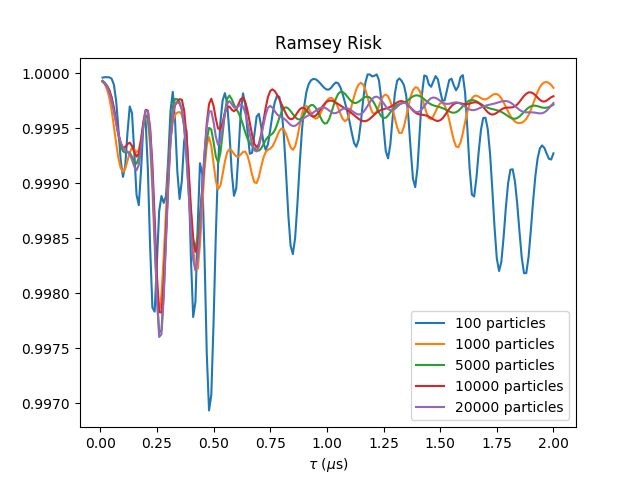

In [9]:
ramsey_eps = ramsey_sweep(max_tau=2, n=200, tp=0.022, wo=0, notp2=False)
fig = plt.figure()

for n_particles in [100,1000,5000,10000,20000]:
    updater = qi.SMCUpdater(par_ex_model, n_particles, extended_prior(10))
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    plt.plot(ramsey_eps['tau'], updater.bayes_risk(ramsey_eps)/risk0, label='{} particles'.format(n_particles))
    
plt.legend()
plt.title('Ramsey Risk')
plt.xlabel(r'$\tau$ ($\mu$s)')

### Ramsey Risk: First Pulse Length vs Ramsey Pulse Length

In [27]:
tp1s = np.linspace(0,0.15,76)[1:]
tp2s = np.linspace(0,0.15,76)[1:]
all_eps = ramsey_sweep(n=tp1s.size*tp2s.size, notp2=False)
all_eps['t'] = np.repeat(tp1s, tp2s.size)
all_eps['tp2'] = np.tile(tp2s, tp1s.size).flatten()
all_eps['tau'] = 0.473

ex_model._Q = np.array([0,1,0,0,0] + [0]*6)
updater = qi.SMCUpdater(par_ex_model, 1000, extended_prior(10))
risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
data = updater.bayes_risk(all_eps) / risk0

<IPython.core.display.Javascript object>


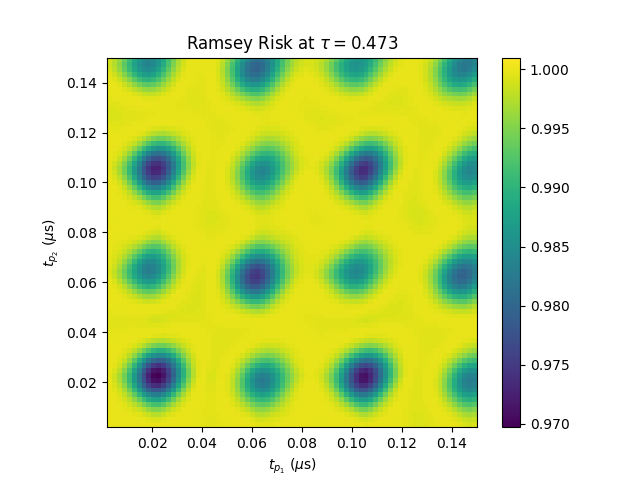

In [28]:
plt.figure()
plt.imshow(data.reshape(tp1s.size,-1), extent=[np.min(tp1s),np.max(tp1s),np.max(tp2s),np.min(tp2s)],vmax=1.001)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel(r'$t_{p_1}$ ($\mu$s)')
plt.ylabel(r'$t_{p_2}$ ($\mu$s)')
plt.title(r'Ramsey Risk at $\tau={}$'.format(float(all_eps['tau'][0])))

In [26]:
 1/ (4 *updater.est_mean()[0])

0.021548199877652097

<IPython.core.display.Javascript object>


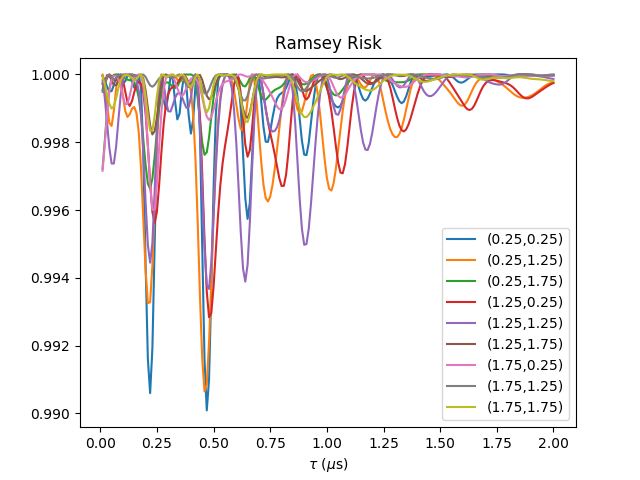

In [31]:
omega_est = updater.est_mean()[1]
modes = np.array([1, 5, 7]) / 4
tp_ests = (1 / omega_est) * modes

ramsey_eps = np.concatenate([
    np.concatenate([
        ramsey_sweep(max_tau=2, n=200, wo=0, tp=tp1, tp2=tp2) 
        for tp1 in tp_ests
    ]) for tp2 in tp_ests
])
fig = plt.figure()
updater = qi.SMCUpdater(par_ex_model, 2000, extended_prior(10))
risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
risks = updater.bayes_risk(ramsey_eps).reshape(tp_ests.size, tp_ests.size, -1) / risk0

for idx_tp1, tp1 in enumerate(tp_ests):
    for idx_tp2, tp2 in enumerate(tp_ests):
        mode1, mode2 = modes[idx_tp1], modes[idx_tp2]
        plt.plot(
            ramsey_eps['tau'][:risks.shape[2]], 
            risks[idx_tp1, idx_tp2, :], 
            label='({},{})'.format(mode1, mode2)
        )
    
plt.legend()
plt.title('Ramsey Risk')
plt.xlabel(r'$\tau$ ($\mu$s)')

### Risk Image: Ramsey Pulse and Wait Time

In [61]:
import scipy.interpolate as si

In [71]:
x = si.RectBivariateSpline(tps,ramsey_eps['tau'], ramsey_risk_tp[1,:,:])

In [30]:
plt.figure()
y = x(np.linspace(0,0.1,200),np.linspace(0,2,500))
plt.imshow(y)

<IPython.core.display.Javascript object>

NameError: name 'x' is not defined

In [97]:
x(0.02, 0.2, grid=True)

array([[ 0.96843081]])

In [68]:
ramsey_sweep(min_tau=0.1,max_tau=0.1,tp=0.1,n=1)

array([( 0.1,  0.1,  0.,  0., 1)],
      dtype=[('t', '<f8'), ('tau', '<f8'), ('phi', '<f8'), ('wo', '<f8'), ('emode', '<i8')])

In [93]:
updater = qi.SMCUpdater(par_ham_model, 1000, custom_prior(mults[1]))
updater.bayes_risk(ramsey_sweep(min_tau=0.2,max_tau=0.2,tp=0.02,n=1)) / np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)

array([ 0.96904246])

In [29]:
mults = np.array([1,10,100])
tps = np.linspace(0,0.1,51)[1:]
rabi_risk_tp = np.empty((mults.size,500))
ramsey_risk_tp = np.empty((mults.size,tps.size,100))

for idx_mult in range(mults.size):
    ham_model._Q = np.array([0,1,0,0,0])
    updater = qi.SMCUpdater(par_ham_model, 1000, custom_prior(mults[idx_mult]))
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    
    rabi_eps = rabi_sweep(max_t=1,n=500,wo=0)
    rabi_risk_tp[idx_mult, :] = updater.bayes_risk(rabi_eps) / risk0
    for idx_tp, tp in enumerate(tps):
        
        ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=tp,wo=0)
        ramsey_risk_tp[idx_mult,idx_tp, :] = updater.bayes_risk(ramsey_eps) / risk0

<IPython.core.display.Javascript object>


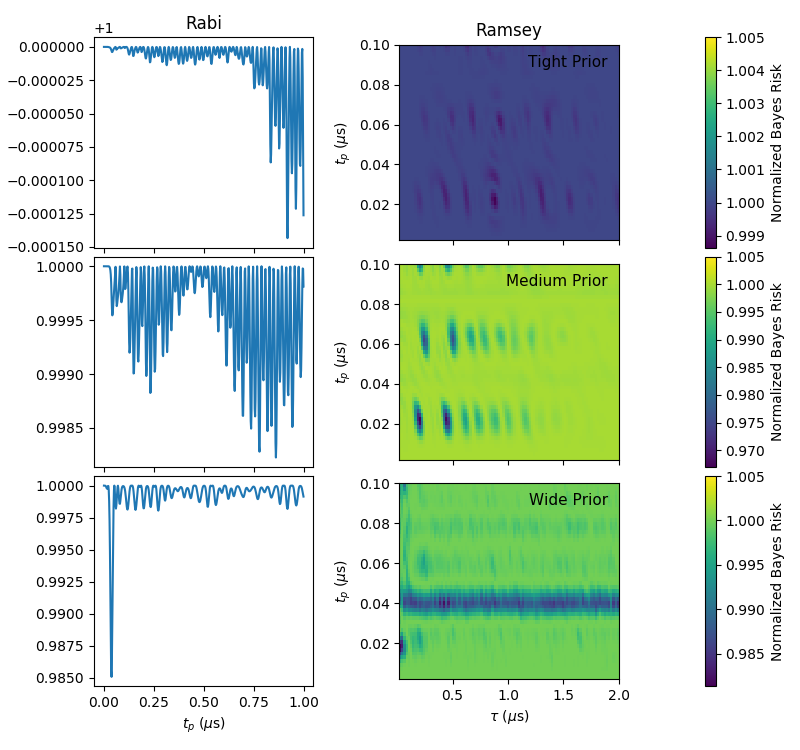

In [39]:
fig = plt.figure(figsize=(8,mults.size * 2.5))
gs = gridspec.GridSpec(mults.size,3, width_ratios=[1,1,0.05])
plt.rc('text', usetex=False)

aspect=9
mult_names = ['Tight Prior','Medium Prior','Wide Prior']

for idx_mult in range(mults.size):
    
    vmin = np.concatenate([rabi_risk_tp[idx_mult,...].flatten(), ramsey_risk_tp[idx_mult,...].flatten()]).min()
    vmax = np.concatenate([rabi_risk_tp[idx_mult,...].flatten(), ramsey_risk_tp[idx_mult,...].flatten()]).max()
    vmax = 1.005

    x_axis = rabi_eps['t']
    ax_rabi = plt.subplot(gs[idx_mult,0])
    plt.plot(x_axis, rabi_risk_tp[idx_mult, ...])
    if idx_mult == 0:
        plt.title('Rabi')
    if idx_mult == mults.size - 1:
        plt.xlabel('$t_p$ ($\mu$s)')
    else:
        plt.setp(ax_rabi.get_xticklabels(), visible=False)

    x_axis = ramsey_eps['tau']
    y_axis = tps
    ax_ramsey = plt.subplot(gs[idx_mult,1])
    im_ramsey = plt.imshow(
        ramsey_risk_tp[idx_mult, ...],
        extent=[x_axis.min(), x_axis.max(), y_axis.max(), y_axis.min()],
        aspect=aspect * ramsey_eps['tau'].max() / rabi_eps['t'].max(),
        vmin=vmin, vmax=vmax
    )
    if idx_mult == 0:
        plt.title('Ramsey')
    if idx_mult == mults.size - 1:
        plt.xlabel(r'$\tau$ ($\mu$s)')
    else:
        plt.setp(ax_ramsey.get_xticklabels(), visible=False)
    plt.ylabel(r'$t_p$ ($\mu$s)')
    plt.text(0.95,0.95,mult_names[idx_mult], size=11, horizontalalignment='right',
        verticalalignment='top', color='black',transform=plt.gca().transAxes)
    ax_ramsey.invert_yaxis()

    ax_cbar = plt.subplot(gs[idx_mult,2])
    fig.colorbar(im_ramsey, cax=ax_cbar)
    plt.ylabel('Normalized Bayes Risk')

    gs.tight_layout(fig, h_pad=0)

#### 11000

In [48]:
mults = np.array([1,10,100])
tps = np.linspace(0,0.1,51)[1:]
rabi_risk_tp = np.empty((mults.size,500))
ramsey_risk_tp = np.empty((mults.size,tps.size,100))

for idx_mult in range(mults.size):
    ham_model._Q = np.array([1,1,0,0,0])
    updater = qi.SMCUpdater(par_ham_model, 1000, custom_prior(mults[idx_mult]))
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    
    rabi_eps = rabi_sweep(max_t=1,n=500,wo=0)
    rabi_risk_tp[idx_mult, :] = updater.bayes_risk(rabi_eps) / risk0
    for idx_tp, tp in enumerate(tps):
        
        ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=tp,wo=0)
        ramsey_risk_tp[idx_mult,idx_tp, :] = updater.bayes_risk(ramsey_eps) / risk0

<IPython.core.display.Javascript object>


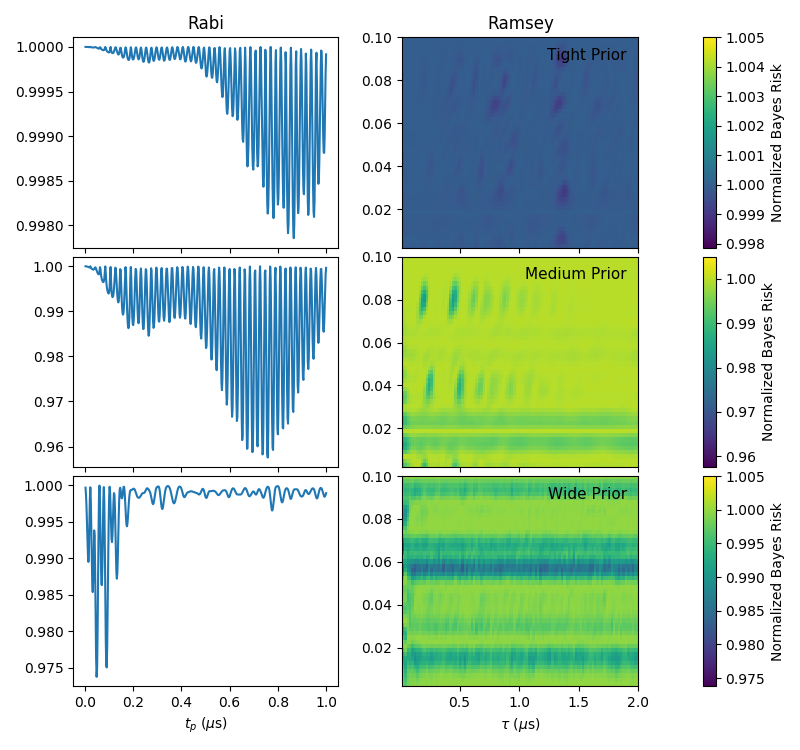

In [49]:
fig = plt.figure(figsize=(8,mults.size * 2.5))
gs = gridspec.GridSpec(mults.size,3, width_ratios=[1,1,0.05])
plt.rc('text', usetex=False)

aspect=9
mult_names = ['Tight Prior','Medium Prior','Wide Prior']

for idx_mult in range(mults.size):
    
    vmin = np.concatenate([rabi_risk_tp[idx_mult,...].flatten(), ramsey_risk_tp[idx_mult,...].flatten()]).min()
    vmax = np.concatenate([rabi_risk_tp[idx_mult,...].flatten(), ramsey_risk_tp[idx_mult,...].flatten()]).max()
    vmax = 1.005

    x_axis = rabi_eps['t']
    ax_rabi = plt.subplot(gs[idx_mult,0])
    plt.plot(x_axis, rabi_risk_tp[idx_mult, ...])
    if idx_mult == 0:
        plt.title('Rabi')
    if idx_mult == mults.size - 1:
        plt.xlabel('$t_p$ ($\mu$s)')
    else:
        plt.setp(ax_rabi.get_xticklabels(), visible=False)

    x_axis = ramsey_eps['tau']
    y_axis = tps
    ax_ramsey = plt.subplot(gs[idx_mult,1])
    im_ramsey = plt.imshow(
        ramsey_risk_tp[idx_mult, ...],
        extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],
        aspect=aspect * ramsey_eps['tau'].max() / rabi_eps['t'].max(),
        vmin=vmin, vmax=vmax
    )
    if idx_mult == 0:
        plt.title('Ramsey')
    if idx_mult == mults.size - 1:
        plt.xlabel(r'$\tau$ ($\mu$s)')
    else:
        plt.setp(ax_ramsey.get_xticklabels(), visible=False)
    plt.text(0.95,0.95,mult_names[idx_mult], size=11, horizontalalignment='right',
        verticalalignment='top', color='black',transform=plt.gca().transAxes)
    #ax_ramsey.invert_yaxis()

    ax_cbar = plt.subplot(gs[idx_mult,2])
    fig.colorbar(im_ramsey, cax=ax_cbar)
    plt.ylabel('Normalized Bayes Risk')

    gs.tight_layout(fig, h_pad=0)

### Risk Image: Pulse/Wait Time and Offset

#### 01000

In [105]:
mults = np.array([1,10,100])
wos = np.linspace(-10,10,31)
n_wos = wos.size
n_mults = mults.size
rabi_risk_wo = np.empty((n_mults,n_wos,100))
ramsey_risk_wo = np.empty((n_mults,n_wos,100))

for idx_mult in range(n_mults):
    ham_model._Q = np.array([0,1,0,0,0])
    updater = qi.SMCUpdater(par_ham_model, 1000, custom_prior(mults[idx_mult]))
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    for idx_wo in range(n_wos):
        rabi_eps = rabi_sweep(max_t=1,n=100,wo=wos[idx_wo])
        ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=0.022,wo=wos[idx_wo])
        rabi_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(rabi_eps) / risk0
        ramsey_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(ramsey_eps) / risk0

<IPython.core.display.Javascript object>


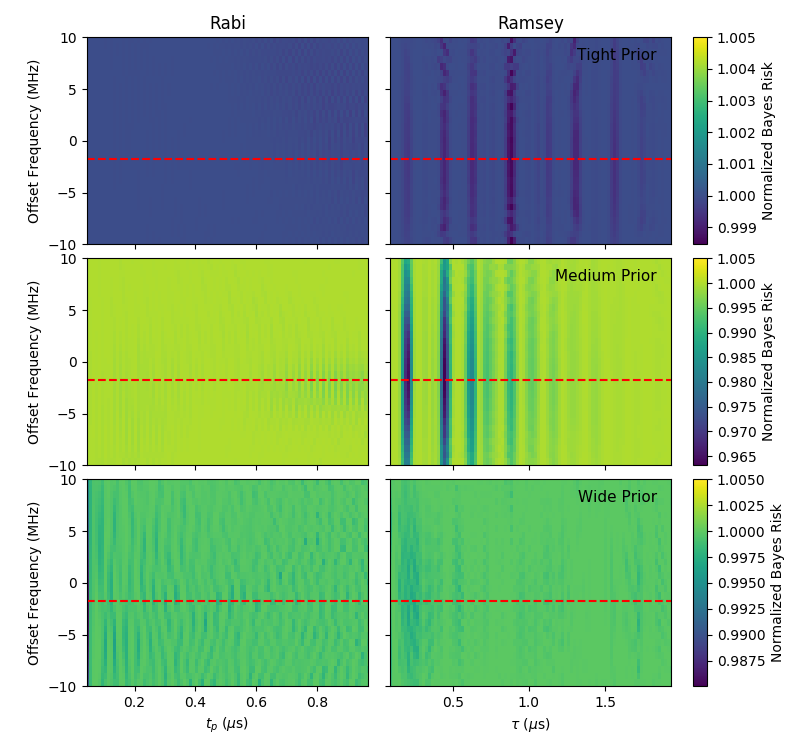

In [106]:
fig = plt.figure(figsize=(8,n_mults * 2.5))
gs = gridspec.GridSpec(n_mults,3, width_ratios=[1,1,0.05])
plt.rc('text', usetex=False)

aspect=0.017 * 2
mult_names = ['Tight Prior','Medium Prior','Wide Prior']

for idx_mult in range(n_mults):
    
    vmin = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).min()
    vmax = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).max()
    vmax = 1.005

    x_axis = rabi_eps['t']
    y_axis = wos
    ax_rabi = plt.subplot(gs[idx_mult,0])
    im_rabi = plt.imshow(
        rabi_risk_wo[idx_mult, ...], 
        aspect=aspect,
        extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],
        vmin=vmin, vmax=vmax#norm=LogNorm(vmin=vmin, vmax=vmax)
    )
    ax_rabi.invert_yaxis()
    if idx_mult == 0:
        plt.title('Rabi')
    if idx_mult == n_mults - 1:
        plt.xlabel('$t_p$ ($\mu$s)')
    else:
        plt.setp(ax_rabi.get_xticklabels(), visible=False)
    plt.ylabel('Offset Frequency (MHz)')
    plt.axhline(-true_value[1], color='r', linestyle='--')

    x_axis = ramsey_eps['tau']
    y_axis = wos
    ax_ramsey = plt.subplot(gs[idx_mult,1], sharey=ax_rabi)
    im_ramsey = plt.imshow(
        ramsey_risk_wo[idx_mult, ...],
        extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],
        aspect=aspect * ramsey_eps['tau'].max() / rabi_eps['t'].max(),
        vmin=vmin, vmax=vmax
    )
    if idx_mult == 0:
        plt.title('Ramsey')
    if idx_mult == n_mults - 1:
        plt.xlabel(r'$\tau$ ($\mu$s)')
    else:
        plt.setp(ax_ramsey.get_xticklabels(), visible=False)
    plt.axhline(-true_value[1], color='r', linestyle='--')
    plt.text(0.95,0.95,mult_names[idx_mult], size=11, horizontalalignment='right',
        verticalalignment='top', color='black',transform=plt.gca().transAxes)

    ax_cbar = plt.subplot(gs[idx_mult,2])
    fig.colorbar(im_rabi, cax=ax_cbar)#, ticks=np.arange(21)/20)
    plt.ylabel('Normalized Bayes Risk')

    plt.setp(ax_ramsey.get_yticklabels(), visible=False)
    gs.tight_layout(fig, h_pad=0)

#### 11000

In [107]:
mults = np.array([1,10,100])
wos = np.linspace(-10,10,31)
n_wos = wos.size
n_mults = mults.size
rabi_risk_wo = np.empty((n_mults,n_wos,100))
ramsey_risk_wo = np.empty((n_mults,n_wos,100))

for idx_mult in range(n_mults):
    ham_model._Q = np.array([1,1,0,0,0])
    updater = qi.SMCUpdater(par_ham_model, 1000, custom_prior(mults[idx_mult]))
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    for idx_wo in range(n_wos):
        rabi_eps = rabi_sweep(max_t=1,n=100,wo=wos[idx_wo])
        ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=0.022,wo=wos[idx_wo])
        rabi_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(rabi_eps) / risk0
        ramsey_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(ramsey_eps) / risk0

<IPython.core.display.Javascript object>


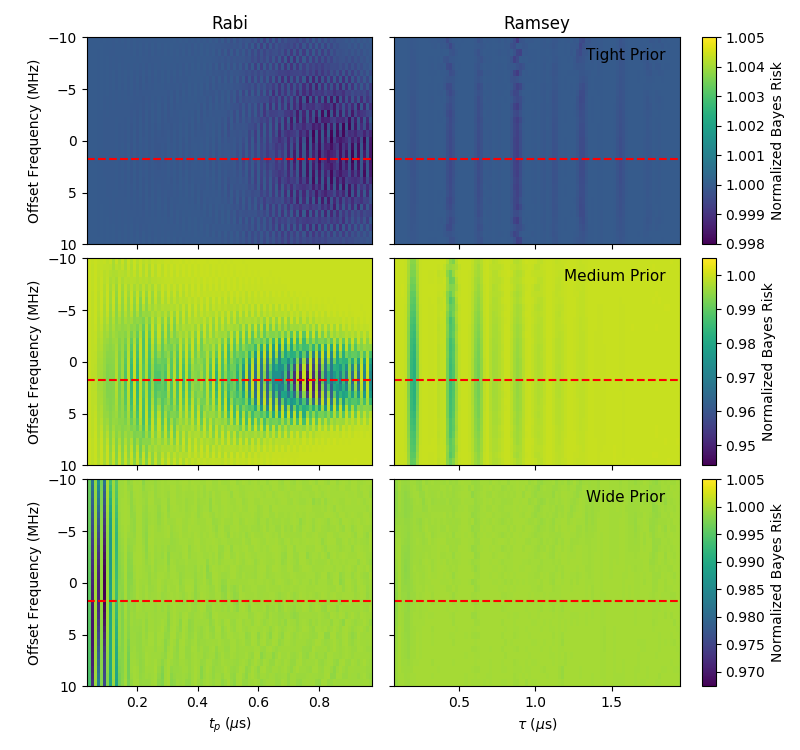

In [110]:
fig = plt.figure(figsize=(8,n_mults * 2.5))
gs = gridspec.GridSpec(n_mults,3, width_ratios=[1,1,0.05])
plt.rc('text', usetex=False)

aspect=0.017 * 2
mult_names = ['Tight Prior','Medium Prior','Wide Prior']

for idx_mult in range(n_mults):
    
    vmin = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).min()
    vmax = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).max()
    vmax = 1.005

    x_axis = rabi_eps['t']
    y_axis = wos
    ax_rabi = plt.subplot(gs[idx_mult,0])
    im_rabi = plt.imshow(
        rabi_risk_wo[idx_mult, ...], 
        aspect=aspect,
        extent=[x_axis.min(), x_axis.max(), y_axis.max(), y_axis.min()],
        vmin=vmin, vmax=vmax#norm=LogNorm(vmin=vmin, vmax=vmax)
    )
    if idx_mult == 0:
        plt.title('Rabi')
    if idx_mult == n_mults - 1:
        plt.xlabel('$t_p$ ($\mu$s)')
    else:
        plt.setp(ax_rabi.get_xticklabels(), visible=False)
    plt.ylabel('Offset Frequency (MHz)')
    plt.axhline(true_value[1], color='r', linestyle='--')

    x_axis = ramsey_eps['tau']
    y_axis = wos
    ax_ramsey = plt.subplot(gs[idx_mult,1], sharey=ax_rabi)
    im_ramsey = plt.imshow(
        ramsey_risk_wo[idx_mult, ...],
        extent=[x_axis.min(), x_axis.max(), y_axis.max(), y_axis.min()],
        aspect=aspect * ramsey_eps['tau'].max() / rabi_eps['t'].max(),
        vmin=vmin, vmax=vmax
    )
    if idx_mult == 0:
        plt.title('Ramsey')
    if idx_mult == n_mults - 1:
        plt.xlabel(r'$\tau$ ($\mu$s)')
    else:
        plt.setp(ax_ramsey.get_xticklabels(), visible=False)
    plt.axhline(true_value[1], color='r', linestyle='--')
    plt.text(0.95,0.95,mult_names[idx_mult], size=11, horizontalalignment='right',
        verticalalignment='top', color='black',transform=plt.gca().transAxes)

    ax_cbar = plt.subplot(gs[idx_mult,2])
    fig.colorbar(im_rabi, cax=ax_cbar)#, ticks=np.arange(21)/20)
    plt.ylabel('Normalized Bayes Risk')

    plt.setp(ax_ramsey.get_yticklabels(), visible=False)
    gs.tight_layout(fig, h_pad=0)

#### 00100

In [111]:
mults = np.array([1,10,100])
wos = np.linspace(-10,10,31)
n_wos = wos.size
n_mults = mults.size
rabi_risk_wo = np.empty((n_mults,n_wos,100))
ramsey_risk_wo = np.empty((n_mults,n_wos,100))

for idx_mult in range(n_mults):
    ham_model._Q = np.array([0,0,1,0,0])
    updater = qi.SMCUpdater(par_ham_model, 1000, custom_prior(mults[idx_mult]))
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    for idx_wo in range(n_wos):
        rabi_eps = rabi_sweep(max_t=1,n=100,wo=wos[idx_wo])
        ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=0.022,wo=wos[idx_wo])
        rabi_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(rabi_eps) / risk0
        ramsey_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(ramsey_eps) / risk0

<IPython.core.display.Javascript object>


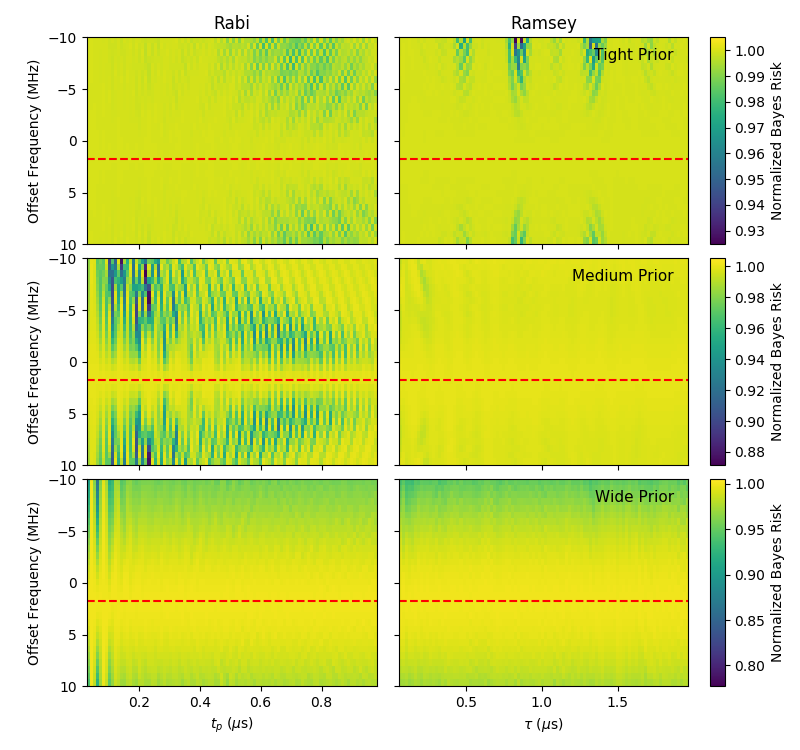

In [112]:
fig = plt.figure(figsize=(8,n_mults * 2.5))
gs = gridspec.GridSpec(n_mults,3, width_ratios=[1,1,0.05])
plt.rc('text', usetex=False)

aspect=0.017 * 2
mult_names = ['Tight Prior','Medium Prior','Wide Prior']

for idx_mult in range(n_mults):
    
    vmin = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).min()
    vmax = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).max()
    vmax = 1.005

    x_axis = rabi_eps['t']
    y_axis = wos
    ax_rabi = plt.subplot(gs[idx_mult,0])
    im_rabi = plt.imshow(
        rabi_risk_wo[idx_mult, ...], 
        aspect=aspect,
        extent=[x_axis.min(), x_axis.max(), y_axis.max(), y_axis.min()],
        vmin=vmin, vmax=vmax#norm=LogNorm(vmin=vmin, vmax=vmax)
    )
    if idx_mult == 0:
        plt.title('Rabi')
    if idx_mult == n_mults - 1:
        plt.xlabel('$t_p$ ($\mu$s)')
    else:
        plt.setp(ax_rabi.get_xticklabels(), visible=False)
    plt.ylabel('Offset Frequency (MHz)')
    plt.axhline(true_value[1], color='r', linestyle='--')

    x_axis = ramsey_eps['tau']
    y_axis = wos
    ax_ramsey = plt.subplot(gs[idx_mult,1], sharey=ax_rabi)
    im_ramsey = plt.imshow(
        ramsey_risk_wo[idx_mult, ...],
        extent=[x_axis.min(), x_axis.max(), y_axis.max(), y_axis.min()],
        aspect=aspect * ramsey_eps['tau'].max() / rabi_eps['t'].max(),
        vmin=vmin, vmax=vmax
    )
    if idx_mult == 0:
        plt.title('Ramsey')
    if idx_mult == n_mults - 1:
        plt.xlabel(r'$\tau$ ($\mu$s)')
    else:
        plt.setp(ax_ramsey.get_xticklabels(), visible=False)
    plt.axhline(true_value[1], color='r', linestyle='--')
    plt.text(0.95,0.95,mult_names[idx_mult], size=11, horizontalalignment='right',
        verticalalignment='top', color='black',transform=plt.gca().transAxes)

    ax_cbar = plt.subplot(gs[idx_mult,2])
    fig.colorbar(im_rabi, cax=ax_cbar)#, ticks=np.arange(21)/20)
    plt.ylabel('Normalized Bayes Risk')

    plt.setp(ax_ramsey.get_yticklabels(), visible=False)
    gs.tight_layout(fig, h_pad=0)

#### Does knowing ZFS actually help?

In [115]:
def zfs_prior(mult):
    return qi.ProductDistribution(
        qi.GammaDistribution(mean=true_value[0], var=(10 * target_stds[0])**2),
        qi.GammaDistribution(mean=true_value[1], var=(10 * target_stds[1])**2),
        qi.NormalDistribution(mean=true_value[2], var=(mult * 10 * target_stds[2])**2),
        qi.GammaDistribution(mean=true_value[3], var=(10 * target_stds[3])**2),
        qi.GammaDistribution(mean=true_value[4], var=(10 * target_stds[4])**2),
    )

mults = np.array([0.001,0.1,1])
wos = np.linspace(-10,10,31)
n_wos = wos.size
n_mults = mults.size
rabi_risk_wo = np.empty((n_mults,n_wos,100))
ramsey_risk_wo = np.empty((n_mults,n_wos,100))

for idx_mult in range(n_mults):
    ham_model._Q = np.array([0,1,0,0,0])
    updater = qi.SMCUpdater(par_ham_model, 1000, zfs_prior(mults[idx_mult]))
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    for idx_wo in range(n_wos):
        rabi_eps = rabi_sweep(max_t=1,n=100,wo=wos[idx_wo])
        ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=0.022,wo=wos[idx_wo])
        rabi_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(rabi_eps) / risk0
        ramsey_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(ramsey_eps) / risk0

<IPython.core.display.Javascript object>


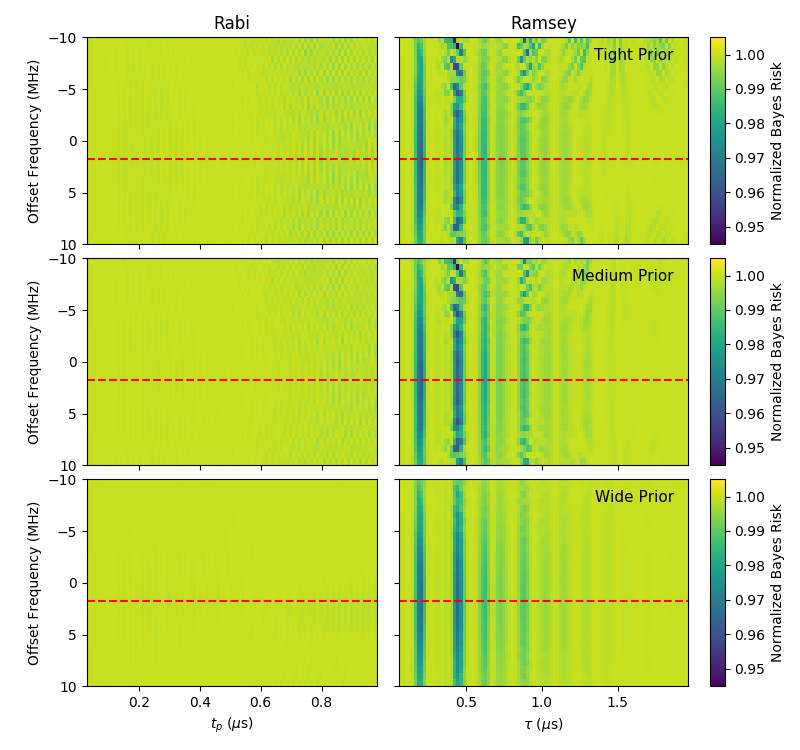

In [117]:
fig = plt.figure(figsize=(8,n_mults * 2.5))
gs = gridspec.GridSpec(n_mults,3, width_ratios=[1,1,0.05])
plt.rc('text', usetex=False)

aspect=0.017 * 2
mult_names = ['Tight Prior','Medium Prior','Wide Prior']

vmin = np.concatenate([rabi_risk_wo.flatten(), ramsey_risk_wo.flatten()]).min()
vmax = np.concatenate([rabi_risk_wo.flatten(), ramsey_risk_wo.flatten()]).max()
vmax = 1.005

for idx_mult in range(n_mults):

    x_axis = rabi_eps['t']
    y_axis = wos
    ax_rabi = plt.subplot(gs[idx_mult,0])
    im_rabi = plt.imshow(
        rabi_risk_wo[idx_mult, ...], 
        aspect=aspect,
        extent=[x_axis.min(), x_axis.max(), y_axis.max(), y_axis.min()],
        vmin=vmin, vmax=vmax#norm=LogNorm(vmin=vmin, vmax=vmax)
    )
    if idx_mult == 0:
        plt.title('Rabi')
    if idx_mult == n_mults - 1:
        plt.xlabel('$t_p$ ($\mu$s)')
    else:
        plt.setp(ax_rabi.get_xticklabels(), visible=False)
    plt.ylabel('Offset Frequency (MHz)')
    plt.axhline(true_value[1], color='r', linestyle='--')

    x_axis = ramsey_eps['tau']
    y_axis = wos
    ax_ramsey = plt.subplot(gs[idx_mult,1], sharey=ax_rabi)
    im_ramsey = plt.imshow(
        ramsey_risk_wo[idx_mult, ...],
        extent=[x_axis.min(), x_axis.max(), y_axis.max(), y_axis.min()],
        aspect=aspect * ramsey_eps['tau'].max() / rabi_eps['t'].max(),
        vmin=vmin, vmax=vmax
    )
    if idx_mult == 0:
        plt.title('Ramsey')
    if idx_mult == n_mults - 1:
        plt.xlabel(r'$\tau$ ($\mu$s)')
    else:
        plt.setp(ax_ramsey.get_xticklabels(), visible=False)
    plt.axhline(true_value[1], color='r', linestyle='--')
    plt.text(0.95,0.95,mult_names[idx_mult], size=11, horizontalalignment='right',
        verticalalignment='top', color='black',transform=plt.gca().transAxes)

    ax_cbar = plt.subplot(gs[idx_mult,2])
    fig.colorbar(im_rabi, cax=ax_cbar)#, ticks=np.arange(21)/20)
    plt.ylabel('Normalized Bayes Risk')

    plt.setp(ax_ramsey.get_yticklabels(), visible=False)
    gs.tight_layout(fig, h_pad=0)

### Risk Heuristic

In [29]:
drift_prior = qi.UniformDistribution(
    [[0.017,0.021],[0.014,0.017]]
)
adaptive_prior = qi.ProductDistribution(custom_prior(2), drift_prior)
adaptive_updater = m.BridgedRPMUpdater(ref_model, 5000, adaptive_prior)

heuristic = RiskHeuristic(
    adaptive_updater, 
    [1,1,1,1,1], 
    rabi_sweep(max_t=1, n=100, n_meas=200000), 
    ramsey_sweep(max_tau=2, n=100, n_meas=200000),
    dview=dview
)

print heuristic(0.022)

[( 0.84,  0.,  0.,  0., 0, 0, 200000)]
